# Schema Subsetting Analysis
This notebook evaluates the subsetting / schema filtering performance of DinSQL and CodeS


```
Copyright 2024 Kyle Luoma

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

In [31]:
import pandas as pd
import os
import seaborn as sns

### Configurations

In [32]:
config_dict = {
    'annotation_dir': './nl-to-sql_performance_annotations/',
    'models': [
        'gemini-1.5-pro-latest', 
        'gpt-4-0125-preview', 
        'gpt-4o',
        'gpt-3.5-turbo', 
        # 'code-bison-32k', 
        # 'code-llama-7b', 
        # 'code-llama-34b'
        'Phind-CodeLlama-34B-v2',
        'DINSQL',
        'CodeS'
        ],
    'model_label_filter': [
        'DINSQL',
        'CodeS'
    ],
    'database': 'all', #Database name or 'all'
    'native_only': True,
    'exclude_spider': True
}
td_dict = {True: 1, False: 0}
nat_cat_dict = {'NATIVE': 0, 'N1': 1, 'N2': 2, 'N3': 3, 'N4': 4}
# cat_label_dict = {'N1': 'Most', 'N2': 'Medium', 'N3': 'Least', 'NATIVE': 'Native', 'combined': 'Combined'}
cat_label_dict = {
    'N1': 'Regular', 
    'N2': 'Low', 
    'N3': 'Least', 
    'N4': 'Regular-Improved',
    'NATIVE': 'Native Schema', 
    'combined': 'Combined'}
model_markers = ['.', '+', '*', 'v', 'x', 'o', "|"][:len(config_dict['model_label_filter'])]
sns.set_theme(style="whitegrid")

### Load Data

In [ ]:
directory = './data/nl-to-sql_performance_annotations'
files = os.listdir(directory)
dinsql_files = [f for f in files if 'DINSQL' in f]

dataframes = []
for file in dinsql_files:
    file_path = os.path.join(directory, file)
    dataframes.append(pd.read_excel(file_path))

din_sql_df = pd.concat(dataframes)
din_sql_df.head(3)

Unnamed: 0.1  number  Unnamed: 0                        database  \
0             0       1           0  ASIS_20161108_HerpInv_Database   
1             1       2           1  ASIS_20161108_HerpInv_Database   
2             2       3           2  ASIS_20161108_HerpInv_Database   

                                            question hints  \
0      How many five year old turtles were measured?    []   
1  How many turtles were measured at each locatio...    []   
2         what is the average weight of all turtles?    []   

                                               notes  \
0  [table_field_data_turtle_measurement_field_dat...   
1  [table_field_data_turtle_measurement_field_dat...   
2  [table_field_data_turtle_measurement_field_dat...   

                                          query_gold  schema_pruning  \
0  select count(*) turtleCount  from tblFieldData...               1   
1  select locationID, count(*) turtleCount from t...               1   
2  select avg(weight) turtleWeight from tblFieldD...               1   

                prompt  ... precision   f1 error_classification  \
0  din-sql muli-prompt  ...  1.000000  1.0                   []   
1  din-sql muli-prompt  ...  0.666667  0.8                   []   
2  din-sql muli-prompt  ...  1.000000  1.0                   []   

  syntax_error_count hallucination_count  misplaced_column_count  \
0                  0                   0                       0   
1                  0                   0                       0   
2                  0                   0                       0   

   manual_match  review_notes  index  level_0  
0             0           NaN    NaN      NaN  
1             1           NaN    NaN      NaN  
2             1           NaN    NaN      NaN  

[3 rows x 72 columns]

In [3]:
directory = './nl-to-sql_performance_annotations'
files = os.listdir(directory)
dinsql_files = [f for f in files if 'CodeS' in f]

dataframes = []
for file in dinsql_files:
    file_path = os.path.join(directory, file)
    dataframes.append(pd.read_excel(file_path))

codes_df = pd.concat(dataframes)
codes_df.head(3)

Unnamed: 0.2  number  Unnamed: 0.1  Unnamed: 0  \
0             0       1             0           0   
1             1       2             1           1   
2             2       3             2           2   

                         database  \
0  ASIS_20161108_HerpInv_Database   
1  ASIS_20161108_HerpInv_Database   
2  ASIS_20161108_HerpInv_Database   

                                            question hints  \
0      How many five year old turtles were measured?    []   
1  How many turtles were measured at each locatio...    []   
2         what is the average weight of all turtles?    []   

                                               notes  \
0  Gold query modified from top to limit for sqli...   
1  Gold query modified from top to limit for sqli...   
2  Gold query modified from top to limit for sqli...   

                                          query_gold  schema_pruning  ...  \
0  select count(*) turtleCount  from tblFieldData...               1  ...   
1  select locationID, count(*) turtleCount from t...               1  ...   
2  select avg(weight) turtleWeight from tblFieldD...               1  ...   

  extra_columns recall precision   f1 error_classification syntax_error_count  \
0         set()    1.0  1.000000  1.0                   []                  0   
1  {'RECORDID'}    1.0  0.666667  0.8                   []                  0   
2         set()    1.0  1.000000  1.0                   []                  0   

   hallucination_count  misplaced_column_count  manual_match  review_notes  
0                    0                       0             1           NaN  
1                    0                       0             0           NaN  
2                    0                       0             1           NaN  

[3 rows x 71 columns]

In [4]:
dbs = din_sql_df.database.unique()
dbs = [db.split("-")[0] for db in dbs]
crosswalk_dict = {}
for db in dbs:
    crosswalk_dict[db] = pd.read_excel(f"./schema-xwalks/consolidated_and_validated/{db}-consolidated-xwalk.xlsx")
    crosswalk_dict[db]["N1_upper"] = crosswalk_dict[db].N1_identifier.str.upper()
    crosswalk_dict[db]["N2_upper"] = crosswalk_dict[db].N2_identifier.str.upper()
    crosswalk_dict[db]["N3_upper"] = crosswalk_dict[db].N3_identifier.str.upper()

In [5]:
crosswalk_dict["ATBI"].head(3)

native_identifier table_or_column source_database native_naturalness  \
0          Author_email          column            ATBI                 N1   
1        Accuracy_Notes          column            ATBI                 N1   
2  Association_observed          column            ATBI                 N1   

          N1_identifier N2_identifier N3_identifier  errors  \
0          Author_email     Authr_eml         A_eml     NaN   
1        Accuracy_Notes     Acc_Notes          A_Nt     NaN   
2  Association_observed     Assoc_obs         A_obs     NaN   

          N4_identifier              N1_upper   N2_upper N3_upper  
0          Author_email          AUTHOR_EMAIL  AUTHR_EML    A_EML  
1        Accuracy_Notes        ACCURACY_NOTES  ACC_NOTES     A_NT  
2  Association_observed  ASSOCIATION_OBSERVED  ASSOC_OBS    A_OBS

#### Load and Process DinSQL

In [6]:
predicted_tables = []
predicted_columns = []
for row in din_sql_df.itertuples():
    if row.notes.strip()[0] == "[" and row.notes.strip()[-1] == "]":
        subset_list = row.notes.replace("[", "").replace("]", "").split(",")
        corrected_subset_list = []
        for s in subset_list:
            if "=" not in s:
                corrected_subset_list.append(s)
            else:
                join_split = s.split("=")
                for js in join_split:
                    corrected_subset_list.append(js.strip())
        question_pred_tables = set()
        question_pred_columns = set()
        for t_c in corrected_subset_list:
            if "." in t_c and "*" not in t_c:
                t = t_c.split(".")[0].strip()
                c = t_c.split(".")[1].strip()
                if row.col_naturalness_modifier != "NATIVE":
                    try:
                        t = crosswalk_dict[row.database.split("-")[0]].query(
                            "table_or_column == 'table'"
                        ).set_index(f"{row.col_naturalness_modifier}_upper").loc[t.upper()]["native_identifier"]
                    except KeyError as e:
                        print(row.database, row.col_naturalness_modifier, t)
                        t = t
                    try:
                        c = crosswalk_dict[row.database.split("-")[0]].query(
                            "table_or_column == 'column'"
                        ).set_index(f"{row.col_naturalness_modifier}_upper").loc[c.upper()]["native_identifier"]
                    except KeyError as e:
                        c = c
                if type(c) != str:
                    c = c.iloc[0]
                if type(t) != str:
                    t = t.iloc[0]
                question_pred_tables.add(t.strip().upper())
                question_pred_columns.add(c.strip().upper())
        predicted_tables.append(question_pred_tables)
        predicted_columns.append(question_pred_columns)
    else:
        predicted_tables.append(set())
        predicted_columns.append(set())

din_sql_df["table_subset_predicted"] = predicted_tables
din_sql_df["column_subset_predicted"] = predicted_columns

ASIS_20161108_HerpInv_Database N3 AVG(LctnPts
ASIS_20161108_HerpInv_Database N3 AVG(LctnPts
ATBI N1 canopy_position_lookup
ATBI N1 canopy_position_lookup
ATBI N2 COUNT(tbl_Deadwood
KlamathInvasiveSpecies N1 table_lookup_species_lava_beds_national_monument
KlamathInvasiveSpecies N1 table_lookup_species_lava_beds_national_monument
KlamathInvasiveSpecies N1 COUNT(table_Locations
KlamathInvasiveSpecies N1 COUNT(table_Locations
KlamathInvasiveSpecies N2 COUNT(tbl_Locations
KlamathInvasiveSpecies N2 COUNT(tbl_Locations
KlamathInvasiveSpecies N3 COUNT(Evs
KlamathInvasiveSpecies N3 COUNT(Locs
NorthernPlainsFireManagement N1 COUNT(table_Tree_Tags
NTSB N2 COUNT(INJUR
NTSB N2 COUNT(INJUR
NYSED_SRC2022 N2 COUNT(BOCES_and_N/RC
NYSED_SRC2022 N3 COUNT(BOCES_and_N/RC
PacificIslandLandbirds N2 COUNT(tbl_Events
PacificIslandLandbirds N2 max(tbl_Stations
PacificIslandLandbirds N3 COUNT(t_Ev
SBODemoUS-Business Partners N2 tgt_grp_dtl
SBODemoUS-Business Partners N2 tgt_grp_dtl
SBODemoUS-Business Partners N

#### Load and Process CodeS

In [7]:
import json
codes_filtered = {}
for nat_level in ["Native", "Regular", "Low", "Least"]:
    codes_filtered[{
        "Native": "NATIVE",
        "Regular": "N1",
        "Low": "N2",
        "Least": "N3"
    }[nat_level]] = json.loads(open(
        f"./schema-tables-json/codes_format/filtered_snails_schemas_and_questions_{nat_level}.json",
        "r"
    ).read())
codes_subset_lookup = {}
for nat_level in codes_filtered:
    for db_schema in codes_filtered[nat_level]:
        codes_subset_lookup[(
            nat_level,
            db_schema["db_id"],
            db_schema["question_number"]
            )] = db_schema["schema"]

In [8]:
codes_filtered["N1"]

[{'db_id': 'ASIS_20161108_HerpInv_Database',
  'db_path': '',
  'schema': {'schema_items': [{'table_name': 'table_lookup_Species',
     'table_comment': '',
     'column_names': ['Species_Code',
      'TaxonomicSerialNumber',
      'Scientific_Name',
      'Common_Name'],
     'column_types': ['nvarchar', 'int', 'nvarchar', 'nvarchar'],
     'column_comments': ['', '', '', ''],
     'column_contents': [[], [], [], []],
     'pk_indicators': [0, 0, 0, 0]},
    {'table_name': 'table_field_data_turtle_measurement_field_data',
     'table_comment': '',
     'column_names': ['Age',
      'RecordID',
      'Species_Code',
      'Sex',
      'EventID',
      'location_id_code',
      'Weight',
      'Behavior',
      'Comments',
      'Tag#'],
     'column_types': ['nvarchar',
      'int',
      'nvarchar',
      'nvarchar',
      'nvarchar',
      'nvarchar',
      'real',
      'nvarchar',
      'nvarchar',
      'nvarchar'],
     'column_comments': ['', '', '', '', '', '', '', '', '', ''],

In [9]:
predicted_tables = []
predicted_columns = []
for row in codes_df.itertuples():
    question_pred_tables = set()
    question_pred_columns = set()
    filtered_schema = codes_subset_lookup[(
        row.col_naturalness_modifier,
        row.database,
        row.number
    )]
    for item in filtered_schema["schema_items"]:
        question_pred_tables.add(item["table_name"])
        question_pred_columns.union(set(item["column_names"]))
    if row.col_naturalness_modifier != "NATIVE":
        modified_question_pred_tables = set()
        modified_question_pred_columns = set()
        for t in question_pred_tables:
            try:
                t = crosswalk_dict[row.database.split("-")[0]].query(
                    "table_or_column == 'table'"
                ).set_index(f"{row.col_naturalness_modifier}_upper").loc[t.upper()]["native_identifier"]
                modified_question_pred_tables.add(t)
                if type(t) != str:
                    t = t.iloc[0]
            except KeyError as e:
                modified_question_pred_tables.add(t)
        for c in question_pred_columns:
            try:
                c = crosswalk_dict[row.database.split("-")[0]].query(
                    "table_or_column == 'column'"
                ).set_index(f"{row.col_naturalness_modifier}_upper").loc[c.upper()]["native_identifier"]
                if type(c) != str:
                    c = c.iloc[0]
                modified_question_pred_columns.add(c)
            except KeyError as e:
                modified_question_pred_columns.add(c)
        question_pred_tables = modified_question_pred_tables
        question_pred_columns = modified_question_pred_columns
    predicted_tables.append(question_pred_tables)
    predicted_columns.append(question_pred_columns)
codes_df["table_subset_predicted"] = predicted_tables
codes_df["column_subset_predicted"] = predicted_columns


### Subsetting Performance Measurements

In [10]:
def convert_string_to_set(s):
    s = s.replace("{", "")
    s = s.replace("}", "")
    s_list = [i.strip().replace("'", "") for i in s.split(",")]
    return set(s_list)
convert_string_to_set("{'INTERNALSN', 'ITEMCODE'}")

{'INTERNALSN', 'ITEMCODE'}

In [11]:
def recall(pred_idents: set, req_idents: set):
    if not req_idents:
        return 1.0
    return len(pred_idents & req_idents) / len(req_idents)
recall({'INTERNALSN'}, {'INTERNALSN', 'ITEMCODE'})

def precision(pred_idents: set, req_idents: set):
    if not pred_idents:
        return 1.0 if not req_idents else 0.0
    return len(pred_idents & req_idents) / len(pred_idents)

precision({'INTERNALSN'}, {'INTERNALSN', 'ITEMCODE'})

def f1_score(pred_idents: set, req_idents: set):
    prec = precision(pred_idents, req_idents)
    rec = recall(pred_idents, req_idents)
    if prec + rec == 0:
        return 0.0
    return 2 * (prec * rec) / (prec + rec)

f1_score({'INTERNALSN'}, {'INTERNALSN', 'ITEMCODE'})

0.6666666666666666

In [12]:
din_sql_df["subsetting_recall"] = din_sql_df.apply(
    lambda row: recall(
        pred_idents=row.table_subset_predicted.union(row.column_subset_predicted),
        req_idents=convert_string_to_set(row.matching_columns).union(
            convert_string_to_set(row.missing_columns)
            ).union(convert_string_to_set(row.matching_tables)).union(
                convert_string_to_set(row.missing_tables)
            )
    ),
    axis=1
)

In [13]:
codes_df["subsetting_recall"] = codes_df.apply(
    lambda row: recall(
        pred_idents=row.table_subset_predicted.union(row.column_subset_predicted),
        req_idents=convert_string_to_set(row.matching_columns).union(
            convert_string_to_set(row.missing_columns)
            ).union(convert_string_to_set(row.matching_tables)).union(
                convert_string_to_set(row.missing_tables)
            )
    ),
    axis=1
)

In [14]:
din_sql_df["subsetting_precision"] = din_sql_df.apply(
    lambda row: precision(
        pred_idents=row.table_subset_predicted.union(row.column_subset_predicted),
        req_idents=convert_string_to_set(row.matching_columns).union(
            convert_string_to_set(row.missing_columns)
            ).union(convert_string_to_set(row.matching_tables)).union(
                convert_string_to_set(row.missing_tables)
            )
    ),
    axis=1
)

In [15]:
codes_df["subsetting_precision"] = codes_df.apply(
    lambda row: precision(
        pred_idents=row.table_subset_predicted.union(row.column_subset_predicted),
        req_idents=convert_string_to_set(row.matching_columns).union(
            convert_string_to_set(row.missing_columns)
            ).union(convert_string_to_set(row.matching_tables)).union(
                convert_string_to_set(row.missing_tables)
            )
    ),
    axis=1
)

In [16]:
din_sql_df["subsetting_f1"] = din_sql_df.apply(
    lambda row: f1_score(
        pred_idents=row.table_subset_predicted.union(row.column_subset_predicted),
        req_idents=convert_string_to_set(row.matching_columns).union(
            convert_string_to_set(row.missing_columns)
            ).union(convert_string_to_set(row.matching_tables)).union(
                convert_string_to_set(row.missing_tables)
            )
    ),
    axis=1
)

In [17]:
codes_df["subsetting_f1"] = codes_df.apply(
    lambda row: f1_score(
        pred_idents=row.table_subset_predicted.union(row.column_subset_predicted),
        req_idents=convert_string_to_set(row.matching_columns).union(
            convert_string_to_set(row.missing_columns)
            ).union(convert_string_to_set(row.matching_tables)).union(
                convert_string_to_set(row.missing_tables)
            )
    ),
    axis=1
)

In [26]:
din_sql_df["model"] = "DINSQL"
codes_df["model"] = "CodeS"
subsetting_df = pd.concat([din_sql_df, codes_df])

In [27]:
subsetting_df.to_excel("./temp_data/subsetting_eval_df.xlsx")

In [28]:
subsetting_df.columns

Index(['Unnamed: 0.1', 'number', 'Unnamed: 0', 'database', 'question', 'hints',
       'notes', 'query_gold', 'schema_pruning', 'prompt',
       'query_predicted_on_naturalized_schema', 'col_naturalness_modifier',
       'tab_naturalness_modifier', 'query_predicted', 'query_stats',
       'Qg_col_N1', 'Qg_tot_cols', 'Qg_col_N2', 'Qg_col_N3', 'Qg_col_N4',
       'Qg_tab_N1', 'Qg_tot_tabs', 'Qg_tab_N2', 'Qg_tab_N3', 'Qg_tab_N4',
       'schema_col_N1', 'schema_col_N2', 'schema_col_N3', 'schema_tab_N1',
       'schema_tab_N2', 'schema_tab_N3', 'schema_tab_count',
       'schema_col_count', 'Qg_col_N1_pct', 'Qg_col_N2_pct', 'Qg_col_N3_pct',
       'Qg_tab_N1_pct', 'Qg_tab_N2_pct', 'Qg_tab_N3_pct', 'schema_col_N1_pct',
       'schema_col_N2_pct', 'schema_col_N3_pct', 'schema_tab_N1_pct',
       'schema_tab_N2_pct', 'schema_tab_N3_pct', 'result_set_match',
       'result_set_compare_note', 'modified_predicted_query',
       'modified_query_result_set_match', 'modified_query_compare_note',
  

In [29]:
subsetting_df["model_abbreviated"] = subsetting_df.model.apply(
    lambda x: {
        'DINSQL': 'GPT-4o-DIN',
        'CodeS': 'Codes-FT'
    }[x])

subsetting_df["model_prompt"] = subsetting_df.model.apply(
    lambda x: {
        'DINSQL': 'GPT-4o-DINSQL',
        'CodeS': 'Codes-FT'
    }[x])

In [42]:
subsetting_df['naturalness'] = subsetting_df.col_naturalness_modifier
subsetting_df['naturalness_label'] = subsetting_df.apply(
    lambda row: cat_label_dict[row.naturalness],
    axis=1
)
subsetting_df['naturalness_order'] = subsetting_df.naturalness_label.apply(
    lambda x: {
        "Native Schema": 0,
        "Regular": 1,
        "Low": 2,
        "Least": 3
    }[x]
)
subsetting_df['model_order'] = subsetting_df.model.apply(
    lambda x: {
        "DINSQL": 1,
        "CodeS": 2
    }[x]
)

C:\Users\kyle.luoma\AppData\Local\Temp\ipykernel_51332\734213256.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([
C:\Users\kyle.luoma\AppData\Local\Temp\ipykernel_51332\734213256.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([
C:\Users\kyle.luoma\AppData\Local\Temp\ipykernel_51332\734213256.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([


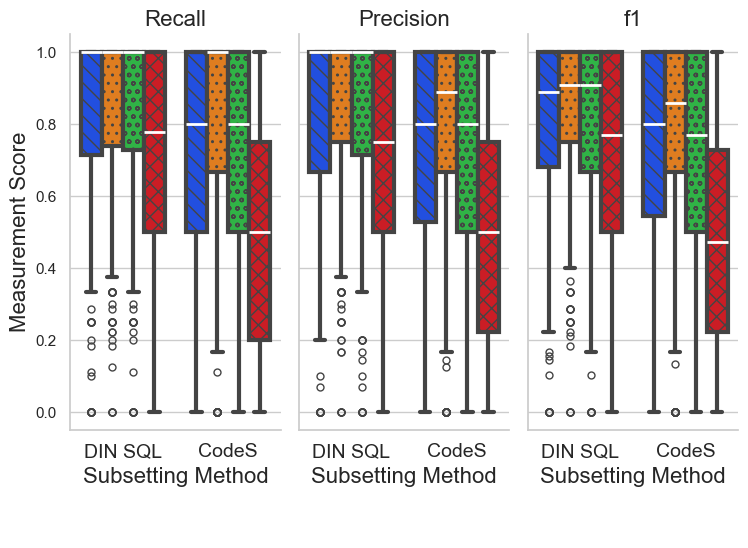

In [91]:
import seaborn as sns
sns.set_theme(style="whitegrid")

sub_melt = subsetting_df.rename(columns={
    "recall": "Recall",
    "precision": "Precision",
    "f1": "f1",
    "naturalness_label": "Level"
}).melt(
    id_vars=["naturalness_order", "model_order", "model_abbreviated", "Level"],
    value_vars=["Recall", "Precision", "f1"],
    value_name="Score",
    var_name="Measurement"
)
sub_melt["Subsetting Method"] = sub_melt.model_abbreviated.apply(
    lambda x: {
        "GPT-4o-DIN": "DIN SQL",#\nGPT-4o Prompt",
        "Codes-FT": "CodeS"#\nFinetuned Classifier"
    }[x]
)

grid = sns.catplot(
    data=sub_melt.sort_values(
            by=[ "naturalness_order", "model_order"]
        ),
    x='Subsetting Method',
    hue='Level',
    y='Score',
    col='Measurement',
    kind='box',
    palette='bright',
    linewidth=3,
    medianprops={'color': 'white', 'ls': 'solid', 'lw': 2},
    legend=False,
    aspect=.5
    # col_wrap=3
    )
grid.set_axis_labels('Subsetting Method', 'Measurement Score', size=16)
hatches = ['\\\\', '..', 'oo', 'xx']
for j, f in enumerate(grid.axes.flat):
    for i, thisbar in enumerate(f.patches):
        if i in [0, 1, 8, 12, 16]:
            thisbar.set_hatch(hatches[0])
        elif i in [2, 3, 9, 13, 17]:
            thisbar.set_hatch(hatches[1])
        elif i in [4, 5, 10, 14, 18]:
            thisbar.set_hatch(hatches[2])
        else:
            thisbar.set_hatch(hatches[3])
grid.add_legend(ncol=4)
grid.legend.set_title('Level', prop={'size': 18})
for ax in grid.axes.flat:
    ax.set_title(ax.get_title().replace("Measurement = ", ""), size=16)
    ax.set_xticklabels([
        l.get_text() 
        for l in ax.get_xticklabels()
        ], size=14)
for entry in grid.legend.get_texts():
    print(entry)
    entry.set_text(entry.get_text().replace(" Schema", ""))
    entry.set_fontsize(16)

for legend_entry, hatch in zip(grid.legend.get_patches(), hatches):
    legend_entry.set_hatch(hatch)

grid.legend.set_bbox_to_anchor((0.5, -0.1))
grid.legend.set_loc('lower center')
grid.legend.set_frame_on(False)


grid.savefig(f"./figure_output/dinsql_codes_subsetting_performance.png", dpi=300)